As a reference for this notebook will be used [Integrated gradients for transformers models](https://docs.seldon.io/projects/alibi/en/stable/examples/integrated_gradients_transformers.html)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pip install -q transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 44.0 MB/s 
     |████████████████████████████████| 6.8 MB 32.0 MB/s 


In [8]:
pip install -q alibi

     |████████████████████████████████| 397 kB 5.6 MB/s 
     |████████████████████████████████| 495.0 MB 30 kB/s 
     |████████████████████████████████| 28.0 MB 54.8 MB/s 
     |████████████████████████████████| 463 kB 31.9 MB/s 
     |████████████████████████████████| 1.3 MB 42.6 MB/s 


In [9]:
from alibi.explainers import IntegratedGradients

In [10]:
import re
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.cm
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
from typing import Optional, Union, List, Dict
from IPython.display import HTML
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import PreTrainedTokenizer

In [11]:
def process_sentences(sentence: List[str],
                      tokenizer: PreTrainedTokenizer,
                      max_len: int) -> Dict[str, np.ndarray]:
    """
    Tokenize the text sentences.

    Parameters
    ----------
    sentence:
        Sentence to be processed.
    tokenizer:
        Tokenizer to be used.

    Returns
    -------
        Tokenized representation containing:
         - input_ids
         - attention_mask
    """
    z = tokenizer(sentence,
                  add_special_tokens=True,
                  padding='max_length',
                  max_length=max_len,
                  truncation=True,
                  return_attention_mask = True,
                  return_tensors='np')
    return z

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Prepare the Inputs**

In [13]:
max_len = 100  #same as BERTForSequenceClassification

In [14]:
train = pd.read_csv("/content/drive/MyDrive/MasterThesis/Dataset/X_train_all.csv")
test = pd.read_csv("/content/drive/MyDrive/MasterThesis/Dataset/X_test_all.csv")

In [15]:
#same reason as BERTForSequenceClassification
train['pad_50_sen'] = train['clean_review'].astype(str).apply(lambda x : ' '.join(x.strip().split(" ")[:50]))
test['pad_50_sen'] = test['clean_review'].apply(lambda x : ' '.join(x.strip().split(" ")[:50]))

In [16]:
X_train = train.pad_50_sen.values.astype(str).tolist()
X_test=test.pad_50_sen.values.astype(str).tolist()

In [17]:
# tokenize datasets
X_train = process_sentences(X_train, tokenizer, max_len)
X_test = process_sentences(X_test, tokenizer, max_len)

In [18]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_train_inputs', 'wb') as f:
    pickle.dump(X_train, f)
    
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_test_inputs', 'wb') as f:
    pickle.dump(X_test, f)    

**Import the Inputs**

In [19]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_train_inputs', 'rb') as f:
    X_train = pickle.load(f)
    
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_test_inputs', 'rb') as f:
    X_test = pickle.load(f)    

In [20]:
train_label = pd.read_csv("/content/drive/MyDrive/MasterThesis/Dataset/y_train_all.csv")
test_label = pd.read_csv("/content/drive/MyDrive/MasterThesis/Dataset/y_test_all.csv")
y_train = train_label.rate
y_test = test_label.rate

In [21]:
from transformers import TFBertModel, BertConfig
config = BertConfig(output_hidden_states=True)
transformer = TFBertModel.from_pretrained('bert-base-uncased', config=config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
class BERT_Classifier(tf.keras.Model):
    def __init__(self,
                 transformer,
                 hidden_dims: int = 128,
                 output_dims: int = 2,
                 dropout_rate: float = 0.2):

        super().__init__()
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        self.dropout_rate = dropout_rate

        self.transformer = transformer
        self.dense_1 = tf.keras.layers.Dense(self.hidden_dims, activation='relu')
        self.dropout_1 = tf.keras.layers.Dropout(self.dropout_rate)
        self.dense_2 = tf.keras.layers.Dense(self.output_dims, activation='sigmoid')

    def call(self,
             input_ids: Union[np.ndarray, tf.Tensor],
             attention_mask: Optional[Union[np.ndarray, tf.Tensor]]=None,
             training=False):

        out = self.transformer(input_ids=input_ids, attention_mask=attention_mask, training=training)
        out = out.last_hidden_state[:, 0, :]  # extract the embedding corresponding to [CLS] token
        out = self.dense_1(out)
        out = self.dropout_1(out, training=training)
        out = self.dense_2(out)
        return out

In [23]:
# define the classification model
model = BERT_Classifier(transformer)

In [24]:
learning_rate = 2e-5
batch_size = 32  #16 or 32
epochs = 3

In [25]:
# compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
filepath = './model_transformers/'
checkpoint_path = os.path.join(filepath, "training/cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [27]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     verbose=1,
                                                     save_weights_only=True,
                                                     save_freq='epoch')

In [28]:
model.fit(x=[X_train['input_ids'], X_train['attention_mask']],
              y=y_train,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[cp_callback])

Epoch 1/3
460/460 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.8809
Epoch 00001: saving model to ./model_transformers/training/cp-0001.ckpt
460/460 [==============================] - 610s 1s/step - loss: 0.2784 - accuracy: 0.8809 - val_loss: 0.2088 - val_accuracy: 0.9119
Epoch 2/3
460/460 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9382
Epoch 00002: saving model to ./model_transformers/training/cp-0002.ckpt
460/460 [==============================] - 580s 1s/step - loss: 0.1635 - accuracy: 0.9382 - val_loss: 0.2032 - val_accuracy: 0.9235
Epoch 3/3
460/460 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9686
Epoch 00003: saving model to ./model_transformers/training/cp-0003.ckpt
460/460 [==============================] - 580s 1s/step - loss: 0.0902 - accuracy: 0.9686 - val_loss: 0.2485 - val_accuracy: 0.9180


**Testing**

In [29]:
# tokenize text
tokenized_samples = X_test
X_test = tokenized_samples['input_ids']

# the values of the kwargs have to be `tf.Tensor`.
kwargs = {k:tf.constant(v) for k, v in tokenized_samples.items() if k == 'attention_mask'}

In [30]:
test_x =test.pad_50_sen.values.astype(str).tolist()

In [31]:
all_pred = []

def pred(i, X_test, max_len):
  X = process_sentences(X_test[i], tokenizer, max_len)
  X_test_s = X
# tokenize text
  tokenized_samples = X_test_s
  X_test_s = tokenized_samples['input_ids']

  kwargs = {k:tf.constant(v) for k, v in tokenized_samples.items() if k == 'attention_mask'}
  predictions = model(X_test_s, **kwargs).numpy().argmax(axis=1)
  all_pred.append(predictions)


In [32]:
for i in range(len(test_x)):  #because there is not enough memroy we calculate the prediction line by line
  pred(i, test_x, 100)

In [33]:
import itertools
y_pred =list(itertools.chain.from_iterable(all_pred))

In [34]:
#with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_keras_pred_propab', 'wb') as f:
 # pickle.dump(y_pred, f)
    
#with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_keras_pred', 'wb') as f:
 # pickle.dump(y_pred, f)    

In [35]:
#with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_keras_pred', 'rb') as f:
 #   y_pred = pickle.load(f)  

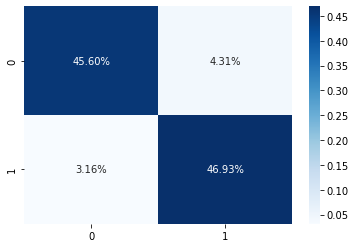

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cf_matrix = confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [37]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2038
           1       0.92      0.94      0.93      2045

    accuracy                           0.93      4083
   macro avg       0.93      0.93      0.93      4083
weighted avg       0.93      0.93      0.93      4083



**Integrated Gradients**

In [38]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_keras_pred', 'rb') as f:
    y_pred = pickle.load(f)  

In [39]:
#showing the results

def  hlstr(string: str , color: str = 'white') -> str:
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"


def colorize(attrs: np.ndarray, cmap: str = 'PiYG') -> List:
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.

    Parameters
    ----------
    attrs:
        Attributions to be visualized.
    cmap:
        Matplotlib cmap type.
    """
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)
    return list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))


def display(X: np.ndarray,
            attrs: np.ndarray,
            tokenizer: PreTrainedTokenizer,
            pred: np.ndarray) -> None:
    """
    Display the attribution of a given instance.

    Parameters
    ----------
    X:
        Instance to display the attributions for.
    attrs:
        Attributions values for the given instance.
    tokenizer:
        Tokenizer to be used for decoding.
    pred:
        Classification label (prediction) for the given instance.
    """
    pred_dict = {1: 'Positive review', 0: 'Negative review'}

    # remove padding
    fst_pad_indices = np.where(X ==tokenizer.pad_token_id)[0]
    if len(fst_pad_indices) > 0:
        X, attrs = X[:fst_pad_indices[0]], attrs[:fst_pad_indices[0]]

    # decode tokens and get colors
    tokens = [tokenizer.decode([X[i]]) for i in range(len(X))]
    colors = colorize(attrs)

    print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))
    return HTML("".join(list(map(hlstr, tokens, colors))))

In [40]:
all_attrs = []

In [41]:
max_len = 100 #just because we lose words from here which we do not lose in other explainers

In [42]:
layer = model.layers[0].bert.embeddings

In [43]:
# define IG
n_steps = 50
method = "gausslegendre"
internal_batch_size = 5

ig  = IntegratedGradients(model,
                          layer=layer,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

In [44]:
#sample_size = 1500 #{845, 1556, 1750, 2150, 2514, 2631, 2652, 2845, 3354, 3447, 3929}
j = 3356

#becase memory is not enough, we get a sample from test to calculate ingradients
X_test_sample = test.pad_50_sen[j:j+2].tolist()
X_test_sample = process_sentences(X_test_sample, tokenizer, max_len)

# tokenize text
tokenized_samples = X_test_sample
X_test_sample = tokenized_samples['input_ids']

# the values of the kwargs have to be `tf.Tensor`.
# see transformers issue #14404: https://github.com/huggingface/transformers/issues/14404
kwargs = {k:tf.constant(v) for k, v in tokenized_samples.items() if k == 'attention_mask'}

In [45]:
sample_prediction = y_pred[j:j+2]
sample_prediction = np.array(sample_prediction)

In [46]:
# construct the baseline as before
mask = np.isin(X_test_sample, tokenizer.all_special_ids)
baselines = X_test_sample * mask + tokenizer.pad_token_id * (1 - mask)

In [47]:
# get explanation
explanation = ig.explain(X_test_sample,
                         forward_kwargs=kwargs,
                         baselines=baselines,
                         target=sample_prediction)

In [48]:
attrs = explanation.attributions[0]
attrs = attrs.sum(axis=2)
#attrs

In [49]:
i = 0
x_i = X_test_sample[i]
attrs_i = attrs[i]
#pred = y_pred[109]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

In [50]:
#with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_ig_all_values', 'wb') as f:
 #   pickle.dump(all_attrs, f)  

In [51]:
i = 0
x_i = X_test_sample[i]
attrs_i = attrs[i]
#pred = y_pred[109]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

#pink - negative attribution  -  decrease in probability of the predicted class
#green - positive attribution - increase in probability of the predicted class 

In [52]:
display(X=X_test_sample[i], attrs=attrs[i], pred=y_pred[j], tokenizer=tokenizer)  ###run the code for X_test[i]

Predicted label =  1: Positive review
